In [1]:
%matplotlib inline

In [2]:
# Reguired libraries
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.basemap import cm as basemap_cm
import seaborn as sns
from collections import OrderedDict
from netCDF4 import num2date
from scipy.stats import ranksums, ttest_ind
from scipy.spatial import ConvexHull
from datetime import datetime
from calendar import month_abbr, month_name
from netCDF4 import date2num, num2date

# RASM lib plotting utilities
from rasmlib.calendar import dpm, day_of_year, to_datetime
from rasmlib.analysis.climatology import season_mean, annual_mean
from rasmlib.analysis.plotting import cmap_discretize, sub_plot_pcolor, projections, default_map, make_bmap, seasons

# Set some general plotting values
fontsize = 7
dpi = 200 # set to 900 for final publication
mpl.rc('font', family='sans-serif') 
mpl.rc('font', serif='Myriad Pro') 
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['mathtext.default'] = 'sf'
mpl.rcParams['pdf.fonttype'] = 42

fill_color = (0.9, 0.9, 0.9)


In [3]:
ncfiles = {}
# Grid and domain files
ncfiles['rasm_domain'] = '/raid2/jhamman/projects/RASM/data/inputdata/CESM/share/domains/domain.lnd.wr50a_ar9v4.100920.nc'
ncfiles['rasm_masks'] = '/raid2/jhamman/projects/RASM/data/inputdata/RASM_VICRVIC_GRID_MASKS_AND_METRICS.nc'

# RASM run files used in this analysis
# daily
ncfiles['rasm_era_daily_ts'] = '/raid2/jhamman/projects/RASM/data/processed/R1003RBRcaaa01a/lnd/daily_mean_timeseries/R1003RBRcaaa01a.vic.hdm.19790901-20131231.nc'
ncfiles['rasm_cfsr_daily_ts'] = '/raid2/jhamman/projects/RASM/data/processed/R1003RBRcaaa01b/lnd/daily_mean_timeseries/R1003RBRcaaa01b.vic.hdm.19790901-20091231.nc'
ncfiles['rasm_offline_daily_ts'] = '/raid2/jhamman/projects/RASM/data/processed/R1003RIRbaaa01e/lnd/daily_mean_timeseries/R1003RIRbaaa01e.vic.hdm.19790901-20080227.nc'

# Comparison datasets

# Spatio-temporal - weekly
ncfiles['nsidc_weekly_ts'] = '/raid2/jhamman/projects/RASM/data/compare/nsidc_snowcover/nsidc_snowcover_V4_wr50a.nc'

# Spatio-temporal - daily
ncfiles['merra_daily_ts'] = '/raid2/jhamman/projects/RASM/data/compare/MERRA/daily/MERRA.prod.assim.tavg1_2d_lnd_Nx.1981-2010.SUB.wr50a.nc'


start='1980-01-01'
end='2014-12-31'

calendars = {}
calendars['NSIDC'] = 'standard'
calendars['$RASM_{ERA}$'] = 'noleap'
calendars['$RASM_{CFSR}$'] = 'noleap'
calendars['$VIC_{S2006}$'] = 'standard'
calendars['MERRA'] = 'standard'

swe_thresh = 1  # mm
frac_thresh = 0.9  # fraction of grid cell that must be land to be included in analysis

In [4]:
ncdata = {}
for k, v in ncfiles.items():
    try:
        print(k)
        ncdata[k] = xr.open_dataset(v)
        if 'time' in ncdata[k]:
            sorts = np.argsort(ncdata[k].time.to_index().to_julian_date())
            if not all(sorts == np.arange(len(sorts))):
                ncdata[k].load()
                ncdata[k] = ncdata[k].isel(time=sorts)
    except:
        print(k, '<---unable to decode time!', )
        ncdata[k] = xr.open_dataset(v, decode_times=False)

# Rename variables in datasets as necessary
name_dicts = {'era_monthly_ts1': {'rsus': 'Swup',
                                  'rsds': 'Swin',
                                  'rlus': 'Lwup',
                                  'rlds': 'Lwin',
                                  'hfss': 'Senht',
                                  'hfls': 'Latht',
                                  'snow_depth': 'Swq',
                                  'precip_tot': 'Precipitation',
                                  'LW_deac_net': 'Lwnet',
                                  'SW_deac_net': 'Swnet',
                                  'west_east': 'x',
                                  'south_north': 'y'},
              'era_monthly_ts2': {'T_2m': 'Tair',
                                  'west_east': 'x',
                                  'south_north': 'y'},
              'era_monthly_ts3': {'tp': 'Precipitation',
                                  'e': 'Evap',
                                  'ro': 'Runoff'},
              'sheffield_monthly_ts':{'tas': 'Tair',
                                      'prcp': 'Precipitation'},
              'merra_monthly_ts': {'prectot': 'Precipitation',
                                   'runoff': 'Runoff',
                                   'baseflow': 'Baseflow',
                                   'shland': 'Senht',
                                   'lhland': 'Latht',
                                   'snomas': 'Swq',
                                   'evland': 'Evap',
                                   'lwland': 'Lwnet',
                                   'swland': 'Swnet',
                                   },
              'merra_daily_ts': {'snomas': 'Swq'},
              'cru_monthly_ts': {'tmp': 'Tair',
                                 'pre': 'Precipitation'},
              'adam_monthly_ts': {'Precip': 'Precipitation'},
              'gfluxnet_monthly_ts': {'EnsembleHcor_May12': 'Senht',
                                      'EnsembleLEcor_May12': 'Latht'},
              'globalbedo_monthly_ts': {'albedo': 'calc_albedo'}
              }

for k, v in ncdata.items():
    if k in name_dicts:
        print(k)
        v.rename(name_dicts[k], inplace=True)

rasm_masks
rasm_offline_daily_ts
merra_daily_ts
nsidc_weekly_ts
rasm_cfsr_daily_ts
rasm_domain
rasm_era_daily_ts
merra_daily_ts


In [5]:
re = 6.37122e6
ncdata['rasm_domain']['area'] *= re * re  # m2
ncdata['rasm_masks']['active N of 50'] = ncdata['rasm_masks']['mask_active_land'].copy()
ncdata['rasm_masks']['active N of 50'].values[ncdata['rasm_domain']['yc'].values < 50.] = 0.
ncdata['rasm_masks']['active N of 50'].values[ncdata['rasm_masks']['active N of 50'].values < frac_thresh] = 0

In [6]:
# Setup rasmlib plotting
wr50a_map = make_bmap(projection=projections['wr50a'],
                      lons=ncdata['rasm_domain']['xc'].values,
                      lats=ncdata['rasm_domain']['yc'].values)
spatial_plot_mask = ncdata['rasm_masks']['mask_active_land'].values < frac_thresh

In [7]:
minor_ticks = [0]
major_ticks = [15.5]
tick_labels = [month_abbr[i] for i in range(1, 13)]
for d in dpm['noleap'][1:-1]:
    major_ticks.append(d+major_ticks[-1])
    minor_ticks.append(d+minor_ticks[-1])

In [8]:
datasets = ['rasm_era_daily_ts', 'rasm_cfsr_daily_ts', 'rasm_offline_daily_ts', 'merra_daily_ts']

land_areas = ncdata['rasm_domain']['area'].values * ncdata['rasm_domain']['frac'].values

for r in datasets:
    ncdata[r]['sca'] = (ncdata[r]['Swq'].sel(time=slice(start, end)) > swe_thresh) * land_areas

# NSIDC
ncdata['nsidc_weekly_ts']['sca'] = (ncdata['nsidc_weekly_ts']['snowice'].sel(time=slice(start, end)) > 0.5) * land_areas

In [9]:
def water_year(time_index, last_month=9):
    year = time_index.to_index().year
    year[time_index.to_index().month > last_month] += 1 
    return xr.DataArray(year, dims=time_index.dims, coords=time_index.coords, name='water_year') 


def snow_disappearance_date(swe, dim='time', thresh=5):
    # create an array of indices the same shape as swe,
    diminds = xr.DataArray(np.arange(swe.time.size), dims=(dim, ), coords=swe.time.coords)
    diminds, _ = xr.broadcast(diminds, swe)
    # Find the indicies of the max swe
    maxinds = swe.argmax(dim=dim)
    # find the index of the first day where swe < thresh
    return (swe < thresh).where(diminds > maxinds).fillna(0).argmax(dim=dim)

In [10]:
swe = ncdata['rasm_era_daily_ts'].Swq
swe = swe.fillna(0)
group_obj = swe.groupby(water_year(swe.time))

In [11]:
no_snow_dates = swe.groupby(water_year(swe.time)).apply(snow_disappearance_date)

In [12]:
mask = ncdata['rasm_masks']['active N of 50'].rename({'nj': 'y', 'ni': 'x'})

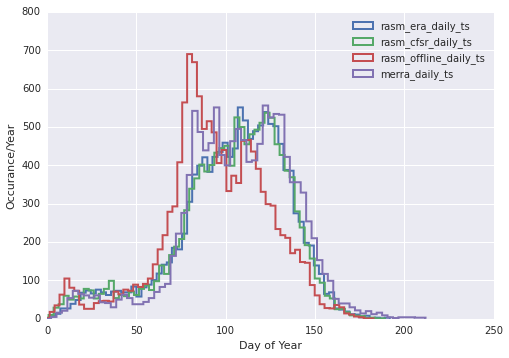

In [13]:
ax = plt.subplot()
for label in ['rasm_era_daily_ts', 'rasm_cfsr_daily_ts', 'rasm_offline_daily_ts', 'merra_daily_ts']:

    swe = ncdata[label].Swq.fillna(0)

    no_snow_dates = swe.groupby(water_year(swe.time)).apply(snow_disappearance_date)
    da = no_snow_dates.where(mask).mean(dim='water_year') - 92

    # make the plot
    data, locs, fig = da.plot.hist(ax=ax, bins=100, histtype='step', lw='2', label=label)
plt.xlim(0, 250)
plt.legend()
plt.xlabel('Day of Year')
plt.ylabel('Occurance/Year')

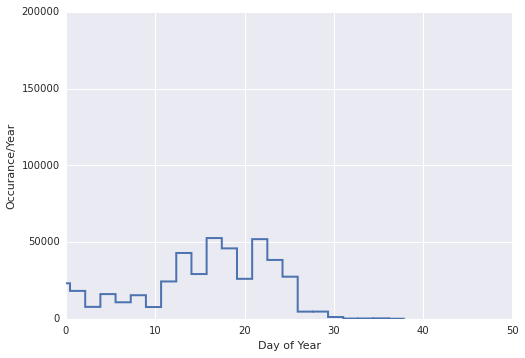

In [39]:
# sca = ncdata['nsidc_weekly_ts'].sca.fillna(0)
# da = sca.groupby(water_year(sca.time)).apply(snow_disappearance_date, thresh=0.5) - (92 / 7)
data, locs, fig = da.plot.hist(bins=30, histtype='step', lw='2') 

plt.ylim(0, 200000)
plt.xlim(0, 50)
# plt.legend()
plt.xlabel('Day of Year')
plt.ylabel('Occurance/Year')

In [25]:
locs

array([-92.  , -91.49, -90.98, -90.47, -89.96, -89.45, -88.94, -88.43,
       -87.92, -87.41, -86.9 , -86.39, -85.88, -85.37, -84.86, -84.35,
       -83.84, -83.33, -82.82, -82.31, -81.8 , -81.29, -80.78, -80.27,
       -79.76, -79.25, -78.74, -78.23, -77.72, -77.21, -76.7 , -76.19,
       -75.68, -75.17, -74.66, -74.15, -73.64, -73.13, -72.62, -72.11,
       -71.6 , -71.09, -70.58, -70.07, -69.56, -69.05, -68.54, -68.03,
       -67.52, -67.01, -66.5 , -65.99, -65.48, -64.97, -64.46, -63.95,
       -63.44, -62.93, -62.42, -61.91, -61.4 , -60.89, -60.38, -59.87,
       -59.36, -58.85, -58.34, -57.83, -57.32, -56.81, -56.3 , -55.79,
       -55.28, -54.77, -54.26, -53.75, -53.24, -52.73, -52.22, -51.71,
       -51.2 , -50.69, -50.18, -49.67, -49.16, -48.65, -48.14, -47.63,
       -47.12, -46.61, -46.1 , -45.59, -45.08, -44.57, -44.06, -43.55,
       -43.04, -42.53, -42.02, -41.51, -41.  ])

In [10]:
def to_datetime(dates):
    return [datetime(*d.timetuple()[:-3]) for d in dates]
# fix daily indexes for rasm datasets
units = 'days since 1979-09-01'
calendar = 'noleap'

for val in ['rasm_era_daily_ts', 'rasm_cfsr_daily_ts']:
    ncdata[val]['time'] = to_datetime(num2date(np.arange(len(ncdata[val].indexes['time'].values)), units, calendar))

In [11]:
small = 0.0001
never_sc = {}
always_sc = {}
invalid = {}
datasets = ['rasm_era_daily_ts', 'rasm_offline_daily_ts', 'merra_daily_ts', 'nsidc_weekly_ts']
for d in datasets:
    data = np.nan_to_num(ncdata[d]['sca'].values)
    never_sc[d] = (data <= small).all(axis=0)
    always_sc[d] = (data > small).all(axis=0)


In [12]:
exclude_cells = np.zeros_like(never_sc[d])
for d in datasets:
    exclude_cells += never_sc[d] + always_sc[d]

ncdata['rasm_masks']['snow mask'] = ~exclude_cells * ncdata['rasm_masks']['mask_active_land'] > frac_thresh
ncdata['rasm_masks']['snow mask N of 50'] = ~exclude_cells * ncdata['rasm_masks']['active N of 50'] > frac_thresh


/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


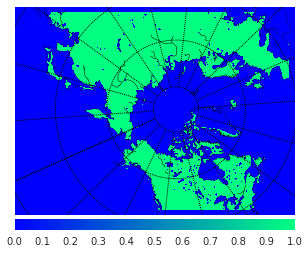

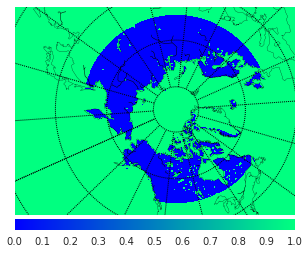

In [13]:
sub_plot_pcolor(ncdata['rasm_masks']['snow mask'].values,
                map_obj=wr50a_map,
                units='', cmap='winter',
                vmin=0, vmax=1)
plt.figure()
sub_plot_pcolor(np.invert(ncdata['rasm_masks']['snow mask N of 50'].values > frac_thresh),
                map_obj=wr50a_map,
                units='', cmap='winter',
                vmin=0, vmax=1)

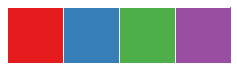

In [14]:
colors = OrderedDict()
current_palette = sns.color_palette(n_colors=4, palette='Set1')

sns.palplot(current_palette)
colors['ERA'] = current_palette[0]
colors['MERRA'] = current_palette[1]
colors['NSIDC'] = current_palette[2]
colors['$RASM_{ERA}$'] = (0, 0, 0)
colors['$RASM_{CFSR}$'] = (0, 0, 0)
colors['$VIC_{S2006}$'] = (0.5, 0.5, 0.5)

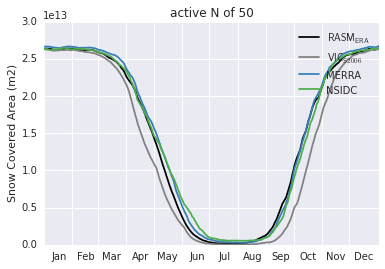

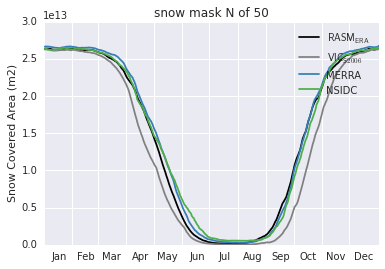

In [15]:
start = '1989-09-01'
end = '2012-08-31'



data = {}

mask_keys = ['mask_tundra', 'mask_boreal_forests_taiga', 'mask_temperate_broadleaf_and_mixed_forests',
             'mask_temperate_grasslands_savannas_and_shrublands', 'mask_temperate_coniferous_forests',
             'mask_active_land', 'mask_rvic_drainage', 'active N of 50', 'snow mask N of 50']

for mask in mask_keys[-2:]:
    ys, xs = np.nonzero(ncdata['rasm_masks'][mask].values * ncdata['rasm_masks']['snow mask'].values)

    for val in ['rasm_era_daily_ts', 'rasm_offline_daily_ts', 'merra_daily_ts', 'nsidc_weekly_ts']:
        ds = ncdata[val].sel(time=slice(start, end))
        label = val.split('_')[0]
        data[val] = pd.Series(data=ds['sca'].values[:, ys, xs].sum(axis=1), index=ds.indexes['time'], name=label)
    data['nsidc_weekly_ts'].index = ncdata['nsidc_weekly_ts']['time_bnds'].sel(time=slice(start, end)).values[:, 0]

    d2 = OrderedDict()

    d2['$RASM_{ERA}$'] = data['rasm_era_daily_ts']
#     d2['$RASM_{CFSR}$'] = data['rasm_cfsr_daily_ts']
    d2['$VIC_{S2006}$'] = data['rasm_offline_daily_ts']
    d2['MERRA'] = data['merra_daily_ts']
    d2['NSIDC'] = data['nsidc_weekly_ts'].resample('D', fill_method='backfill')
    fig, ax = plt.subplots()
                        
    for k, s in d2.items():
        s.groupby(day_of_year(s.index, calendars[k])).mean().plot(label=k, color=colors[k])
    plt.title(mask)
    plt.ylabel('Snow Covered Area (m2)')
    ax.set_xticks(major_ticks, minor=False)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticklabels(tick_labels)
    ax.grid(True, which='minor', axis='x')
    ax.grid(False, which='major', axis='x')
    plt.legend()

$RASM_{ERA}$
$VIC_{S2006}$
MERRA
NSIDC


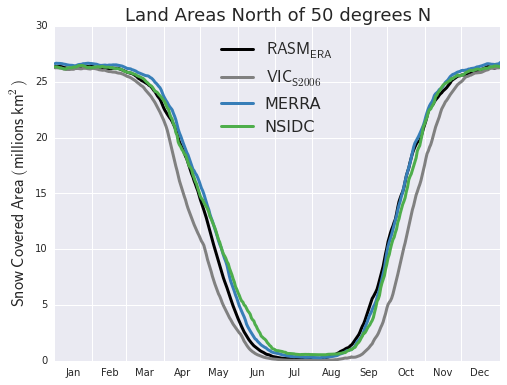

In [16]:
d2 = OrderedDict()

m2_to_millionkm = 1. / 1000. / 1000. / 1000000

d2['$RASM_{ERA}$'] = data['rasm_era_daily_ts'] * m2_to_millionkm
# d2['$RASM_{CFSR}$'] = data['rasm_cfsr_daily_ts'] * m2_to_millionkm
d2['$VIC_{S2006}$'] = data['rasm_offline_daily_ts'] * m2_to_millionkm
d2['MERRA'] = data['merra_daily_ts'] * m2_to_millionkm
d2['NSIDC'] = data['nsidc_weekly_ts'].resample('D', fill_method='backfill') * m2_to_millionkm
fig, ax = plt.subplots(figsize=(8, 6))

for k, s in d2.items():
    print(k)
    s.groupby(day_of_year(s.index, calendars[k])).mean().plot(label=k, color=colors[k], lw=3, ax=ax)
plt.title('Land Areas North of 50 degrees N', fontsize=18)
plt.ylabel('$Snow\ Covered\ Area\ (millions\ km^{2})$', fontsize=16)
ax.set_xticks(major_ticks, minor=False)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(tick_labels)
ax.grid(True, which='minor', axis='x')
ax.grid(False, which='major', axis='x')
plt.legend(loc=9, fontsize=16)
# plt.savefig('sca-annual-cycle.pdf')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


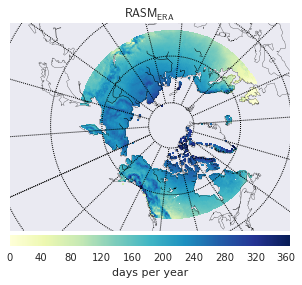

In [17]:
# map of # of days that are snow covered per year
da = ncdata['rasm_era_daily_ts']['Swq'].sel(time=slice(start, end))
data_array = (da.resample('7D', how='mean', dim='time') > swe_thresh).groupby('time.year').sum(dim='time').mean(dim='year').values
sub_plot_pcolor(np.ma.masked_where(ncdata['rasm_masks']['snow mask N of 50'].values < frac_thresh, data_array * 7),
                map_obj=wr50a_map,
                units='days per year', vmin=0, vmax=365,
                cmap='YlGnBu')
plt.title('$RASM_{ERA}$')
drasm = data_array

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


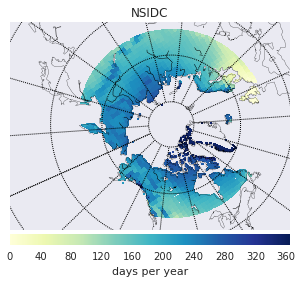

In [18]:
da = ncdata['nsidc_weekly_ts']['snowice'].sel(time=slice(start, end)).resample('7D', how='mean', dim='time')
data_array = (da > 0.5).groupby('time.year').sum(dim='time').mean(dim='year').values
sub_plot_pcolor(np.ma.masked_where(ncdata['rasm_masks']['snow mask N of 50'].values < frac_thresh, data_array * 7),
                map_obj=wr50a_map,
                units='days per year', vmin=0, vmax=365,
                cmap='YlGnBu')
plt.title('NSIDC')
dnsidc = data_array

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


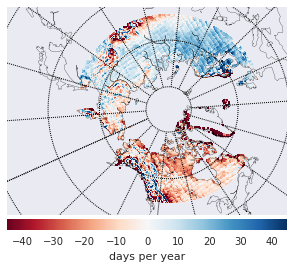

In [19]:
data_array = drasm - dnsidc
sub_plot_pcolor(np.ma.masked_where(ncdata['rasm_masks']['snow mask N of 50'].values < frac_thresh, data_array) * 7,
                map_obj=wr50a_map,
                units='days per year', vmin=-45, vmax=45,
                cmap='RdBu')

# plt.contourf(data, 20, cmap='RdBu')
# plt.colorbar()

In [ ]:
cn = 12
vmin = 0
vmax = 360
cmap = cmap_discretize('Spectral_r', n_colors=cn)
cnorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cticks = np.linspace(vmin, vmax, num=cn + 1)
an = 9
amin = -45
amax = 45
amap = cmap_discretize('RdBu', n_colors=an)
anorm = mpl.colors.Normalize(vmin=amin, vmax=amax)
aticks = np.linspace(amin, amax, num=an + 1)

In [ ]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(9, 8))

mask_where = np.invert(ncdata['rasm_masks']['snow mask N of 50'].values > 0)

ax = axes[0, 0]
plt.sca(ax)
ax.set_title('$RASM_{ERA}$')
wr50a_map.m.drawmapboundary(fill_color=fill_color)
sub_plot_pcolor(np.ma.masked_where(mask_where, drasm * 7),
                map_obj=wr50a_map,
                units='days per year', vmin=vmin, vmax=vmax,
                cmap=cmap, cbar=None)

ax = axes[0, 1]
plt.sca(ax)
ax.set_title('NSIDC')
wr50a_map.m.drawmapboundary(fill_color=fill_color)
sub_plot_pcolor(np.ma.masked_where(mask_where, dnsidc * 7),
                map_obj=wr50a_map,
                units='days per year', vmin=0, vmax=365,
                cmap=cmap, cbar=None)

ax = axes[1, 0]
plt.sca(ax)
ax.set_title('$RASM_{ERA}$ - NSIDC')
diff = drasm - dnsidc
wr50a_map.m.drawmapboundary(fill_color=fill_color)
sub_plot_pcolor(np.ma.masked_where(mask_where, diff * 7),
                map_obj=wr50a_map,
                units='days per year', vmin=amin, vmax=amax,
                cmap=amap, cbar=None)

d2 = OrderedDict()
m2_to_millionkm = 1. / 1000. / 1000. / 1000000
d2['$RASM_{ERA}$'] = data['rasm_era_daily_ts'] * m2_to_millionkm
# d2['$RASM_{CFSR}$'] = data['rasm_cfsr_daily_ts'] * m2_to_millionkm
d2['$VIC_{S2006}$'] = data['rasm_offline_daily_ts'] * m2_to_millionkm
d2['MERRA'] = data['merra_daily_ts'] * m2_to_millionkm
d2['NSIDC'] = data['nsidc_weekly_ts'].resample('D', fill_method='backfill') * m2_to_millionkm

plt.sca(axes[1, 1])

ax = axes[1, 1]

lines = []
labels = []
for k, s in d2.items():
    labels.append(k)
    ax = s.groupby(day_of_year(s.index, calendars[k])).mean().plot(color=colors[k], lw=2, ax=ax)
plt.title('Land Areas North of 50$^\circ$ N')
plt.ylabel('$Snow\ Covered\ Area\ (millions\ km^{2})$')
ax.set_xticks(major_ticks, minor=False)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(tick_labels, rotation=40, ha='center')
ax.grid(True, which='minor', axis='x')
ax.grid(False, which='major', axis='x')
plt.legend(ax.lines, labels, loc=9, frameon=True)  # something weird was going on so I had to manually collect the legend entries
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3, bottom=0.15, right=0.95, left=0.05)
ax1 = fig.add_axes([0.1, 0.6, 0.8, 0.02])
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=cnorm,
                                orientation='horizontal',
                                extend='neither',
                                ticks=cticks)
cb1.set_label('Days Per Year')
ax2 = fig.add_axes([0.05, 0.13, 0.4, 0.02])
cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=amap, norm=anorm,
                                orientation='horizontal',
                                extend='both',
                                ticks=aticks)
cb2.set_label('Days Per Year')

# plt.savefig('rasm1_snow_plot.pdf', dpi=dpi, bbox_inches='tight')
fig.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Figure_08.pdf'), dpi=dpi, bbox_inches='tight')

In [ ]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(9, 8))

mask_where = np.invert(ncdata['rasm_masks']['snow mask N of 50'].values > 0)

ax = axes[0, 0]
plt.sca(ax)
ax.set_title('$RASM_{ERA}$')
wr50a_map.m.drawmapboundary(fill_color=fill_color)
sub_plot_pcolor(np.ma.masked_where(mask_where, drasm * 7),
                map_obj=wr50a_map,
                units='days per year', vmin=vmin, vmax=vmax,
                cmap=cmap, cbar=None)

ax = axes[0, 1]
plt.sca(ax)
ax.set_title('NSIDC')
wr50a_map.m.drawmapboundary(fill_color=fill_color)
sub_plot_pcolor(np.ma.masked_where(mask_where, dnsidc * 7),
                map_obj=wr50a_map,
                units='days per year', vmin=0, vmax=365,
                cmap=cmap, cbar=None)

ax = axes[1, 0]
plt.sca(ax)
ax.set_title('$RASM_{ERA}$ - NSIDC')
diff = drasm - dnsidc
wr50a_map.m.drawmapboundary(fill_color=fill_color)
sub_plot_pcolor(np.ma.masked_where(mask_where, diff * 7),
                map_obj=wr50a_map,
                units='days per year', vmin=amin, vmax=amax,
                cmap=amap, cbar=None)

d2 = OrderedDict()
m2_to_millionkm = 1. / 1000. / 1000. / 1000000
d2['$RASM_{ERA}$'] = data['rasm_era_daily_ts'] * m2_to_millionkm
# d2['$RASM_{CFSR}$'] = data['rasm_cfsr_daily_ts'] * m2_to_millionkm
# d2['$VIC_{S2006}$'] = data['rasm_offline_daily_ts'] * m2_to_millionkm
d2['MERRA'] = data['merra_daily_ts'] * m2_to_millionkm
d2['NSIDC'] = data['nsidc_weekly_ts'].resample('D', fill_method='backfill') * m2_to_millionkm

plt.sca(axes[1, 1])

ax = axes[1, 1]

lines = []
labels = []
for k, s in d2.items():
    labels.append(k)
    ax = s.groupby(day_of_year(s.index, calendars[k])).mean().plot(color=colors[k], lw=2, ax=ax)
plt.title('Land Areas North of 50$^\circ$ N')
plt.ylabel('$Snow\ Covered\ Area\ (millions\ km^{2})$')
ax.set_xticks(major_ticks, minor=False)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(tick_labels, rotation=40, ha='center')
ax.grid(True, which='minor', axis='x')
ax.grid(False, which='major', axis='x')
plt.legend(ax.lines, labels, loc=9)  # something weird was going on so I had to manually collect the legend entries
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3, bottom=0.15, right=0.95, left=0.05)
ax1 = fig.add_axes([0.1, 0.6, 0.8, 0.02])
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=cnorm,
                                orientation='horizontal',
                                extend='neither',
                                ticks=cticks)
cb1.set_label('Days Per Year')
ax2 = fig.add_axes([0.05, 0.13, 0.4, 0.02])
cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=amap, norm=anorm,
                                orientation='horizontal',
                                extend='both',
                                ticks=aticks)
cb2.set_label('Days Per Year')

plt.savefig('rasm1_snow_plot_simple.pdf', dpi=dpi, bbox_inches='tight')

In [ ]:
ax = plt.subplot()
lines = []
labels = []
for k, s in d2.items():
    labels.append(k)
    s.groupby(day_of_year(s.index, calendars[k])).mean().plot(color=colors[k], lw=2)
plt.title('Land Areas North of 50$^\circ$ N')
plt.ylabel('$Snow\ Covered\ Area\ (millions\ km^{2})$')
ax.set_xticks(major_ticks, minor=False)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(tick_labels, rotation=40, ha='center')
ax.grid(True, which='minor', axis='x')
ax.grid(False, which='major', axis='x')
plt.xlim([75, 200])
plt.legend(ax.lines, labels, loc=9)  # something weird was going on so I had to manually collect the legend entries
plt.tight_layout()


plt.savefig('rasm1_snow_plot_simple_zoom_in.pdf', dpi=dpi, bbox_inches='tight')

In [ ]:
# # map of # of days that are snow covered per year
da = ncdata['rasm_era_daily_ts']['sca'].sel(time=slice(start, end))
data_array = (da.groupby('time.month').mean(dim='time').sel(month=5)).values / ncdata['rasm_domain']['area'] 

sub_plot_pcolor(np.ma.masked_where(ncdata['rasm_masks']['snow mask N of 50'].values < frac_thresh, data_array),
                map_obj=wr50a_map,
                cmap='YlGnBu')
plt.title('$RASM_{ERA}$')
drasm = data_array

In [ ]:
# # map of # of days that are snow covered per year
da = ncdata['nsidc_weekly_ts']['sca'].sel(time=slice(start, end))
data_array = (da.groupby('time.month').mean(dim='time').sel(month=5)).values / ncdata['rasm_domain']['area'] 

sub_plot_pcolor(np.ma.masked_where(ncdata['rasm_masks']['snow mask N of 50'].values < frac_thresh, data_array),
                map_obj=wr50a_map,
                vmin=0, vmax=1,
                cmap='YlGnBu')
plt.title('NSIDC')
dnsidc = data_array

In [ ]:


sns.set_style("whitegrid")

cn = 10
vmin=0
vmax=1
cmap = cmap_discretize('Spectral_r', n_colors=cn)
cnorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cticks = np.linspace(vmin, vmax, num=cn + 1)
an = 9
amin = -0.9
amax = 0.9
amap = cmap_discretize('RdBu', n_colors=an)
anorm = mpl.colors.Normalize(vmin=amin, vmax=amax)
aticks = np.linspace(amin, amax, num=an + 1)




fig, axes = plt.subplots(2, 2, figsize=(9, 8))

mask_where = np.invert(ncdata['rasm_masks']['snow mask N of 50'].values > 0)

vmin=0
vmax=1

ax = axes[0, 0]
plt.sca(ax)
ax.set_title('$RASM_{ERA}$')
wr50a_map.m.drawmapboundary(fill_color=fill_color)
sub_plot_pcolor(np.ma.masked_where(mask_where, drasm),
                map_obj=wr50a_map,
                units='fractional snow coverage', vmin=vmin, vmax=vmax,
                cmap=cmap, cbar=None)

ax = axes[0, 1]
plt.sca(ax)
ax.set_title('NSIDC')
wr50a_map.m.drawmapboundary(fill_color=fill_color)
sub_plot_pcolor(np.ma.masked_where(mask_where, dnsidc),
                map_obj=wr50a_map,
                units='fractional snow coverage', vmin=vmin, vmax=vmax,
                cmap=cmap, cbar=None)

ax = axes[1, 0]
plt.sca(ax)
ax.set_title('$RASM_{ERA}$ - NSIDC')
diff = drasm - dnsidc
wr50a_map.m.drawmapboundary(fill_color=fill_color)
sub_plot_pcolor(np.ma.masked_where(mask_where, diff),
                map_obj=wr50a_map,
                units='fractional snow coverage', vmin=-1, vmax=1,
                cmap=amap, cbar=None)

d2 = OrderedDict()
m2_to_millionkm = 1. / 1000. / 1000. / 1000000
d2['$RASM_{ERA}$'] = data['rasm_era_daily_ts'] * m2_to_millionkm
# d2['$RASM_{CFSR}$'] = data['rasm_cfsr_daily_ts'] * m2_to_millionkm
# d2['$VIC_{S2006}$'] = data['rasm_offline_daily_ts'] * m2_to_millionkm
d2['MERRA'] = data['merra_daily_ts'] * m2_to_millionkm
d2['NSIDC'] = data['nsidc_weekly_ts'].resample('D', fill_method='backfill') * m2_to_millionkm

plt.sca(axes[1, 1])

ax = axes[1, 1]

lines = []
labels = []
for k, s in d2.items():
    labels.append(k)
    ax = s.groupby(day_of_year(s.index, calendars[k])).mean().plot(color=colors[k], lw=2, ax=ax)
plt.title('Land Areas North of 50$^\circ$ N')
plt.ylabel('$Snow\ Covered\ Area\ (millions\ km^{2})$')
ax.set_xticks(major_ticks, minor=False)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(tick_labels, rotation=40, ha='center')
ax.grid(True, which='minor', axis='x')
ax.grid(False, which='major', axis='x')
plt.legend(ax.lines, labels, loc=9)  # something weird was going on so I had to manually collect the legend entries
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3, bottom=0.15, right=0.95, left=0.05)
plt.xlim([75, 200])

ax1 = fig.add_axes([0.1, 0.6, 0.8, 0.02])
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=cnorm,
                                orientation='horizontal',
                                extend='neither',
                                ticks=cticks)
cb1.set_label('Fraction of time grid cell is covered with snow')
ax2 = fig.add_axes([0.05, 0.13, 0.4, 0.02])
cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=amap, norm=anorm,
                                orientation='horizontal',
                                extend='both',
                                ticks=aticks)
cb2.set_label('-')

plt.savefig('rasm1_snow_plot_simple_may_fractional.pdf', dpi=dpi, bbox_inches='tight')